## Implement of a curvature tensor

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

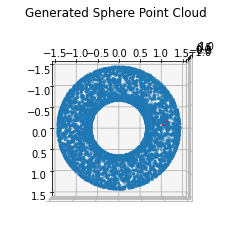

In [6]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus, torus_centers = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5)
ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=50, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 0)
plt.show()

In [22]:
idx =2000
query = torus[idx].reshape(1, -1)


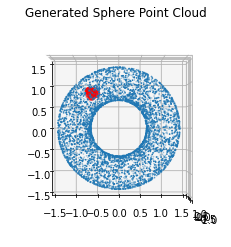

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=0.5)
ax.scatter(torus[ep_idx[0]][:, 0], torus[ep_idx[0]][:, 1], torus[ep_idx[0]][:, 2], s=50, c = 'r')
ax.scatter(torus[idx, 0], torus[idx, 1], torus[idx, 2], s=50, c = 'blue')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(-90, 0)
plt.show()

In [78]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4, return_dim = False):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True)
    sorted_neighbors = sorted(zip(tau_dist[0], tau_idx[0]))
    sorted_dist, sorted_ind = zip(*sorted_neighbors)
    tau_nbrs = point_cloud[list(sorted_ind)]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    if return_dim:
        x_idx = sorted_ind[0]
        lpca = skdim.id.lPCA().fit_pw(point_cloud, n_neighbors = 10, n_jobs = 1)
        dim = lpca.dimension_pw_[x_idx]
        return tau_nbrs, dim, O
    else:
        return tau_nbrs, O
    
        
    

In [58]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(torus)
ep_dist, ep_idx = nbrs.radius_neighbors(query, 0.4, return_distance=True)



In [59]:
sorted_neighbors = sorted(zip(ep_dist[0], ep_idx[0]))

# Extract sorted distances and indices
sorted_distances, sorted_indices = zip(*sorted_neighbors)

# Now, point_cloud[sorted_indices] will be ordered from nearest to farthest
sorted_neighbors_points = torus[list(sorted_indices)]

In [74]:
sorted_indices[0]

2000

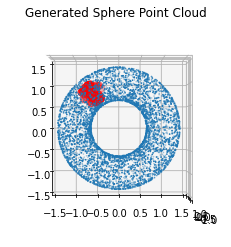

In [69]:
nn = 70
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=0.5)
ax.scatter(sorted_neighbors_points[:nn, 0], 
           sorted_neighbors_points[:nn, 1], sorted_neighbors_points[:nn, 2], s=50, c = 'r')
ax.scatter(torus[idx, 0], torus[idx, 1], torus[idx, 2], s=50, c = 'blue')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(-90, 0)
plt.show()

In [79]:
tau_nbrs, O = find_basis(torus, query,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4)

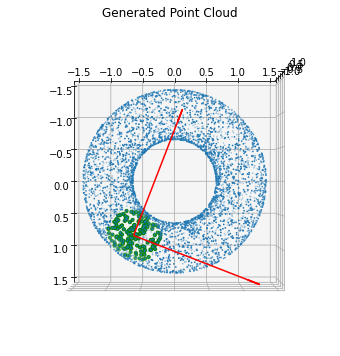

In [80]:
def plot_vector(ax, a, v, color='red', label=None):
    ax.quiver(a[0], a[1], a[2], v[0], v[1], v[2], color=color, label=label, arrow_length_ratio=0.1)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=0.5)
ax.scatter(tau_nbrs[:, 0], tau_nbrs[:, 1], tau_nbrs[:, 2], s=10, c= 'green')
plot_vector(ax, torus[idx], 2 * O[0])
plot_vector(ax, torus[idx], 2 * O[1])
ax.set_title("Generated Point Cloud")
ax.view_init(90, 0)
plt.axis('equal')
plt.show()

In [116]:
def compute_sectional_curvature(point_cloud, query_point, extrin_dim = 3, 
                                epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    tensor_all = []
    for i in np.arange(1, len(tau_nbrs)):
        tensor = 2 * (sum(O[2] *  (tau_nbrs[i] - tau_nbrs[0])))/np.linalg.norm(tau_nbrs[i] - tau_nbrs[0])**2
        tensor_all.append(tensor)
        
    
    #tensor_av = sum(tensor_av)/len(tensor_av)
    #max_cur = sorted(tensor_all, reverse=True)[:max_min_num]
    max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num
    #min_cur = sorted(tensor_all)[:max_min_num]
    
    min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur
 

In [108]:
compute_sectional_curvature(torus_cloud, torus_cloud[0].reshape(1, -1), 
                            extrin_dim = 3, epsilon_PCA =0.1, tau_radius = 0.4)

-4.5380254586686375

In [132]:
num_eval = int(len(torus_cloud))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_sectional_curvature(torus, torus[i].reshape(1, -1), 
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 100)
    curvature.append(b)

100%|██████████| 5000/5000 [01:09<00:00, 72.22it/s]


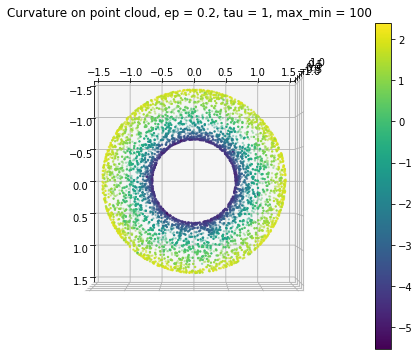

In [133]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep = 0.2, tau = 1, max_min = 100")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

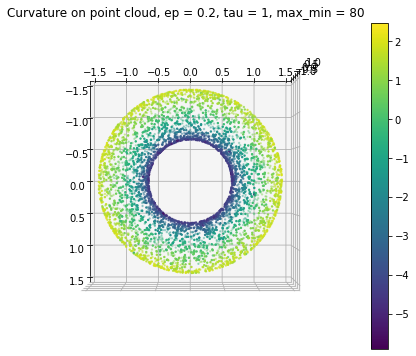

In [128]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep = 0.2, tau = 1, max_min = 80")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [111]:
dd = np.clip(v, a_max=None, a_min=-10)

In [134]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

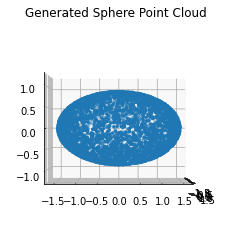

In [135]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

In [136]:
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_sectional_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 100)
    curvature.append(b)

100%|██████████| 5000/5000 [00:51<00:00, 97.24it/s] 


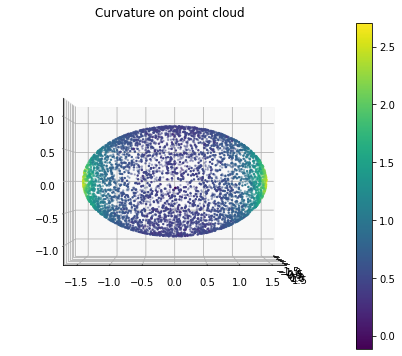

In [139]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [409]:
dd = np.clip(v, a_max=5, a_min=None)